### Evaluate Topic Model in Python: Latent Dirichlet Allocation (LDA)

###  Calculating Topic Coherence.

Perplexity is often used as an example of an intrinsic evaluation measure. It comes from the language modeling community and aims to capture how surprised a model is of new data it has not seen before. It is measured as the normalized log-likelihood of a held-out test set.

Focussing on the log-likelihood part, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

However, past research has shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. And that served as a motivation for more work trying to model the human judgment, and thus `Topic Coherence`.

The topic coherence concept combines a number of papers into one framework that allows evaluating the coherence of topics inferred by a topic model. But,

#### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But,

#### What is coherence?
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is "the game is a team sport", "the game is played with a ball", "the game demands great physical efforts"

### Coherence Measures

1. `C_v` measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2. `C_p` is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson's coherence
3. `C_uci` measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4. `C_umass` is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5. `C_npmi` is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6. `C_a` is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

### Model Implementation
1. Loading Data
2. Data Cleaning
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data Transformation: Corpus and Dictionary
5. Base Model
6. Hyper-parameter Tuning
7. Final model
8. Visualize Results


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving news_articles.csv to news_articles.csv


In [ ]:
# Importing modules
import pandas as pd
# import os

# os.chdir('..')

# Read data into papers
papers = pd.read_csv('news_articles.csv')

# Print head
papers.head()

,Unnamed: 0,Headline,Content
0,0,"IMD: Clear skies, less intense heat over Pune ...",Heat conditions over Pune were relatively less...
1,1,Arvind Kejriwal says no plan for lockdown in D...,Even as the Covid-19 cases continue to rise in...
2,2,BJP opposes Pune administration’s decision to ...,The BJP on Friday slammed the Pune administrat...
3,3,Body of Delhi Police constable’s wife found ha...,A Delhi Police constable’s wife allegedly hang...
4,4,"Pune: HSC board exams from April 23, hall tick...",– Stay updated with the latest Pune news. Foll...


** **
#### Step 2: Data Cleaning
** **



In [ ]:
# Remove the columns
papers = papers.drop(columns=['Headline'], axis=1)

# sample only 100 papers
papers = papers.sample(100)

# Print out the first rows of papers
papers.head()

,Unnamed: 0,Content
623,623,The Jawaharlal Nehru University Teachers’ Asso...
2797,497,Rajkummar Rao shared picture of his body trans...
373,373,"An elevated section of the Dwarka Expressway, ..."
809,109,India’s cotton and sugar sectors have welcomed...
2245,145,Abu Dhabi's removing curbs with aim of opening...


##### Remove punctuation/lower casing



In [ ]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['Content'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

623     the jawaharlal nehru university teachers’ asso...
2797    rajkummar rao shared picture of his body trans...
373     an elevated section of the dwarka expressway t...
809     india’s cotton and sugar sectors have welcomed...
2245    abu dhabi's removing curbs with aim of opening...
Name: paper_text_processed, dtype: object

##### Tokenize words and further clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['the', 'jawaharlal', 'nehru', 'university', 'teachers', 'association', 'jnuta', 'wednesday', 'alleged', 'that', 'the', 'current', 'registrar', 'anirban', 'chakraborti', 'was', 'appointed', 'illegally', 'by', 'vice', 'chancellor', 'jagadesh', 'kumar', 'who', 'is', 'on', 'an', 'extension', 'after', 'his']


** **
#### Step 3: Phrase Modeling: Bigram and Trigram Models
** **

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order.

In [ ]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['allege', 'current', 'anirban', 'appoint', 'illegally', 'tenure', 'officially', 'end', 'approval', 'statutory', 'bodiesthey', 'also', 'allege', 'first', 'time', 'history', 'name', 'even', 'university', 'statute', 'say', 'meet', 'schedule', 'also', 'say', 'name', 'bring', 'decision', 'make', 'body']


** **
#### Step 4: Data transformation: Corpus and Dictionary
** **

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 4), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 4), (21, 1), (22, 4), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


** **
#### Step 5: Base Model 
** **

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

Chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

Passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"share" + 0.016*"post" + 0.015*"see" + 0.012*"picture" + 0.010*"film" '
  '+ 0.008*"also" + 0.008*"say" + 0.008*"look" + 0.008*"actress" + '
  '0.008*"actor"'),
 (1,
  '0.014*"case" + 0.014*"say" + 0.011*"patient" + 0.009*"also" + 0.009*"year" '
  '+ 0.008*"get" + 0.006*"report" + 0.006*"tell" + 0.006*"military" + '
  '0.005*"officer"'),
 (2,
  '0.024*"say" + 0.013*"also" + 0.008*"state" + 0.008*"take" + 0.008*"year" + '
  '0.006*"government" + 0.005*"vaccine" + 0.005*"come" + 0.005*"tell" + '
  '0.005*"file"'),
 (3,
  '0.019*"say" + 0.012*"goal" + 0.008*"score" + 0.008*"second" + 0.007*"play" '
  '+ 0.007*"take" + 0.007*"last" + 0.006*"come" + 0.006*"go" + 0.005*"team"'),
 (4,
  '0.015*"say" + 0.011*"farmer" + 0.007*"village" + 0.007*"race" + '
  '0.006*"start" + 0.005*"land" + 0.005*"government" + 0.005*"second" + '
  '0.005*"make" + 0.005*"seek"'),
 (5,
  '0.020*"say" + 0.011*"police" + 0.010*"run" + 0.006*"stage" + 0.006*"take" + '
  '0.006*"yuvraj" + 0.005*"person" +

#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3119138339217926


** **
#### Step 6: Hyperparameter tuning
** **
First, let's differentiate between model hyperparameters and model parameters :

- `Model hyperparameters` can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- `Model parameters` can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters: 
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use `C_v` as our choice of metric for performance comparison 

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 6
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.4))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.4))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('Final_coherence.csv', index=False)
    pbar.close()


  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)

100%|██████████| 360/360 [22:24<00:00,  3.73s/it]


In [ ]:
df = pd.DataFrame(model_results)
  
# saving the dataframe
df.to_csv('Final_Coherence.csv')
# from google.colab import files
files.download("Final_Coherence.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#df.loc[[179]]
df_75 = df.iloc[:179,:]
df_100 = df.iloc[180:,:]

#### Coherence Score across different Alpha and beta for 75% and 100% of the corpus

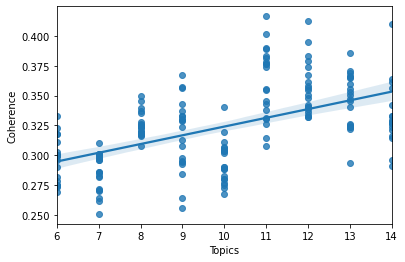

In [ ]:
import seaborn as sns
# df = sns.load_dataset('iris')

# use the function regplot to make a scatterplot
sns.regplot(x=df_75["Topics"], y=df_75["Coherence"])

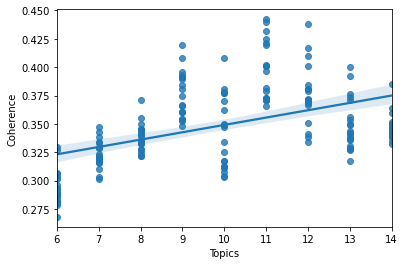

In [ ]:
import seaborn as sns
# df = sns.load_dataset('iris')

# use the function regplot to make a scatterplot
sns.regplot(x=df_100["Topics"], y=df_100["Coherence"])

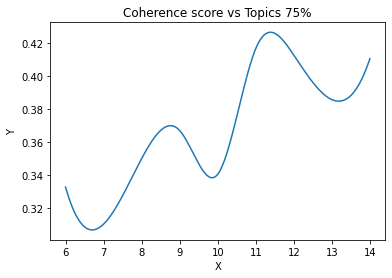

In [ ]:
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array(index_list)
y = np.array(max_list)
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Coherence score vs Topics 75%")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

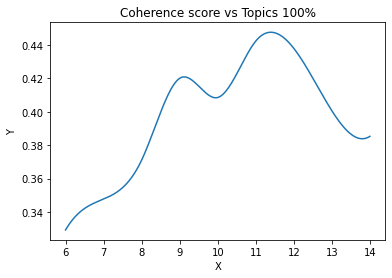

In [ ]:
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array(index_list)
y = np.array(max_list)
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Coherence score vs Topics 100%")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

** **
#### Step 7: Final Model
** **

Based on external evaluation (Code to be added from Excel based analysis), let's train the final model with parameters yielding highest coherence score

In [ ]:
num_topics = 11

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"see" + 0.008*"share" + 0.007*"post" + 0.005*"picture" + 0.005*"film" '
  '+ 0.005*"also" + 0.004*"look" + 0.004*"actor" + 0.004*"write" + '
  '0.004*"actress"'),
 (1,
  '0.006*"case" + 0.006*"say" + 0.004*"year" + 0.003*"patient" + 0.003*"get" + '
  '0.003*"military" + 0.002*"officer" + 0.002*"district" + 0.002*"report" + '
  '0.002*"also"'),
 (2,
  '0.009*"say" + 0.003*"also" + 0.003*"state" + 0.002*"take" + 0.002*"video" + '
  '0.002*"year" + 0.002*"go" + 0.002*"government" + 0.002*"come" + '
  '0.002*"would"'),
 (3,
  '0.008*"say" + 0.005*"goal" + 0.004*"score" + 0.004*"second" + 0.003*"last" '
  '+ 0.003*"play" + 0.003*"take" + 0.002*"make" + 0.002*"go" + 0.002*"give"'),
 (4,
  '0.004*"farmer" + 0.003*"village" + 0.002*"protest" + 0.002*"movement" + '
  '0.001*"say" + 0.001*"land" + 0.001*"give" + 0.001*"start" + 0.001*"kill" + '
  '0.001*"even"'),
 (5,
  '0.009*"say" + 0.006*"police" + 0.003*"stage" + 0.002*"kill" + '
  '0.002*"people" + 0.002*"leader" + 0.002*"gove

** **
#### Step 8: Visualize Results
** **

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.029086 -0.041226       1        1  17.792584
7     -0.045132  0.009268       2        1  17.125357
3     -0.012703  0.021879       3        1  13.785167
0      0.040411 -0.020938       4        1  11.584883
6      0.003003  0.021637       5        1   7.322463
5      0.004748  0.003742       6        1   7.212435
2      0.007446 -0.003161       7        1   6.922087
10     0.003931  0.003831       8        1   6.839125
1     -0.003748 -0.009884       9        1   6.742402
9      0.015146  0.006480      10        1   3.348378
4      0.015983  0.008371      11        1   1.325120, topic_info=            Term       Freq      Total Category  logprob  loglift
116        share  21.000000  21.000000  Default  30.0000  30.0000
99          post  22.000000  22.000000  Default  29.0000  29.0000
537       police  23.000000  23.000000  Default  28.0000  28.0000
114          see  35.000000  35.000000  Default  27.0000  27.0000
1113    football  13.000000  13.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
19           day   0.177430  26.316259  Topic11  -7.2341  -0.6757
1           also   0.177347  47.250632  Topic11  -7.2345  -1.2614
145           go   0.177199  35.328531  Topic11  -7.2354  -0.9715
215   government   0.177139  26.048331  Topic11  -7.2357  -0.6671
58          time   0.176796  26.417348  Topic11  -7.2376  -0.6831

[620 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1592      1  0.190434  accident
1592      2  0.190434  accident
1592      8  0.380868  accident
473       1  0.181977    accuse
473       2  0.090988    accuse
...     ...       ...       ...
271       8  0.024026      year
271       9  0.096103      year
271      10  0.024026      year
766       1  0.108571    yuvraj
766       2  0.651424    yuvraj

[1415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 4, 1, 7, 6, 3, 11, 2, 10, 5])

Intertropic Distance Map using pyLDAvis was made using two different values of no. of components i.e. 10 and 11.Better cluster representation is observed for no. of components equal to 10

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared